# Neural Networks for Data Science Applications
## End-of-term homework: Recurrent neural networks and autoregressive modelling

**Name**: *Saeed Zohoorianmofatkharkhodaparast*

**Matricola**: *1955809*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 20th** session, you should upload it by **January 17th, 23:59 Rome time**.

In [15]:
import os, csv, ast, math, time, re, functools
os.environ["XLA_FLAGS"] = (
    "--xla_cpu_multi_thread_eigen=true "
    "intra_op_parallelism_threads=2 "
    "inter_op_parallelism_threads=2"
)

import jax
from jax import lax, nn, random as jrand
import jax.numpy as jnp
from jax import config as jconfig
try:
    jconfig.update("jax_default_matmul_precision", "high")
except Exception as e:
    print("matmul precision tweak not applied:", e)

import matplotlib.pyplot as plt
import kagglehub

### Instructions

1. The homework is divided into three exercises. The first two (**10 points**) are mandatory for everyone. The third one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>. **Same goes for LLM-generated material**.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (no external libraries) and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

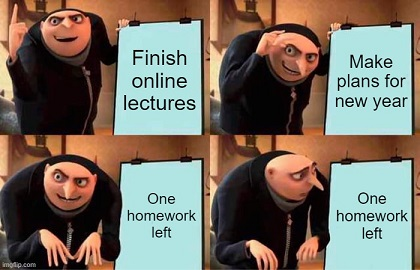

## Warmup: Data loading

For this part, select a dataset that is adequate for an autoregressive modelling task, keeping in mind task complexity with respect to the available hardware. Alternatively, take a generic dataset and transform it in a suitable way. Some examples (non exhaustive list):

1. Any text dataset can be converted to a next-token prediction dataset. You are free to use an existing tokenizer or train the tokenizer from scratch.
2. Time series are also naturally convertible to autoregressive scenarios.
3. For images you can convert them in multiple ways, e.g., as a sequence of pixels, as a sequence of patches (as in ViTs), as a sequence of bytes...
4. Other types of data, such as audio, graphs, DNA sequences, etc., are also feasible based on your interest.

> ⭕ For this homework, creativity is appreciated! Look around in the literature for inspiration (e.g., PixelRNN, pixel language modeling, audio autoregression, conditional models, ...). The fancier the better, according to your judgment.

*   You can use any data processing you want here (PyTorch data loaders, TensorFlow datasets, Grain, HuggingFace Dataset, ...).
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code. Describe the preprocessing you have applied. Show some examples of tokenized sequences and / or some statistics (e.g., tokens count, sequence length, ...).*

---

**Dataset description**

- **Name of Dataset:**  
  - DailyDialog — Multi-turn Dialogues with Intention and Emotion Labels  

- **Source:**  
  - The dataset is provided on Kaggle and originally curated to reflect natural daily human conversations across various topics. It contains high-quality, human-written dialogues that capture both **communication intentions** and **emotional expressions**.  

- **Link to Dataset:**  
  - https://www.kaggle.com/datasets/thedevastator/dailydialog-multi-turn-dialog-with-intention-and  

- **About the Dataset:**  
  - Each entry contains a full multi-turn conversation between two or more participants, represented in text form.  
  - Alongside each conversation, there are two label sets:
    - **act:** Communication intention labels indicating the purpose behind each utterance (e.g., question, statement, request).  
    - **emotion:** Emotion labels describing the emotional tone expressed (e.g., happiness, sadness, anger).  
  - The dataset is split into three parts: **train.csv**, **validation.csv**, and **test.csv** for model training, validation, and evaluation.  
  - It is particularly suitable for training models that need to understand conversational flow, speaker turns, and emotional cues.

---

**Preprocessing**

1. **Download the dataset** from Kaggle using KaggleHub and load the three CSV files: `train.csv`, `validation.csv`, and `test.csv`.  
2. **Parse the dialogues** by reading the `dialog` column from each CSV file. Each dialogue is stored as a list of utterances (text lines between speakers).  
3. **Clean the text** using a preprocessing function that:
   - Converts text to lowercase,  
   - Normalizes punctuation (quotes, dashes, etc.),  
   - Removes extra whitespace,  
   - Limits excessive punctuation (e.g., “!!!” → “!!”),  
   - Trims spaces around the text.  
4. **Add structure tokens** to preserve dialogue flow and speaker identity:
   - `␂` — Beginning of Sequence (BOS)  
   - `␞` — End of Sequence (EOS)  
   - `①` — Speaker A  
   - `②` — Speaker B  
   - This results in formatted text such as:  
     ```
     ␂①hi, how are you?
     ②i’m fine, thanks!␞
     ```
5. **Build a character-level vocabulary** from the training data, collecting all unique characters and mapping each to a unique integer ID.  
6. **Encode dialogues into integer sequences**, where each character is replaced with its corresponding ID to prepare the data for a character-level model.  
7. **Create fixed-length input-output pairs (windows)** for next-character prediction. Each pair `(x, y)` represents one sequence of characters and the same sequence shifted by one step forward.  
8. **Convert sequences into tensors** (`x_train`, `y_train`, `x_val`, `y_val`, `x_test`, `y_test`) ready for model training.

---

- **Example:**  
  The cleaned and tokenized data is transformed into character-level streams, enabling the model to learn from sequential text patterns and predict the next character in multi-turn dialogues.  

- **Goal:**  
  We use this preprocessed dataset to train a **character-level dialogue model** capable of understanding conversation structure, speaker turns, intentions, and emotional context in natural daily interactions.


In [16]:
# --------------------------
# FAST MODE switch
# --------------------------
FAST_MODE = False

# --------------------------
# Hyperparameters (CPU-friendly)
# --------------------------
if FAST_MODE:
    SEQUENCE_LENGTH = 96
    EMBED_DIM       = 192
    HIDDEN_SIZE     = 256
    BATCH_SIZE      = 96
    EPOCHS          = 36
    STEPS_PER_EPOCH_CAP = 320
    USE_LAYER_NORM  = False   # learnable gamma/beta
else:
    SEQUENCE_LENGTH = 128
    EMBED_DIM       = 256
    HIDDEN_SIZE     = 384
    BATCH_SIZE      = 32
    EPOCHS          = 36
    STEPS_PER_EPOCH_CAP = None
    USE_LAYER_NORM  = True

LEARNING_RATE   = 1e-3
GRAD_CLIP_NORM  = 1.0
BASE_SEED       = 42

# Regularization
WEIGHT_DECAY     = 1e-5
EMB_DROPOUT      = 0.05   # variational (locked across time)
HIDDEN_DROPOUT   = 0.05
OUT_DROPOUT      = 0.00
WARMUP_FRACTION  = 0.03

# Readout tying
TIE_WEIGHTS      = True
USE_PROJ         = True

# EMA
EMA_DECAY                = 0.999
EMA_UPDATE_EVERY_N_STEPS = 1   # every step

# Decoding defaults
TOPP_P           = 0.92
REP_PENALTY      = 1.15
BEAM_SIZE        = 4
BEAM_LEN_ALPHA   = 0.65
DEFAULT_TEMP     = 0.85


# ============================================================
# == STEP 1: Download & load DailyDialog ==
# ============================================================
print("== STEP 1: Download DailyDialog from KaggleHub ==")
DATA_DIR = kagglehub.dataset_download(
    "thedevastator/dailydialog-multi-turn-dialog-with-intention-and"
)
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
VAL_CSV   = os.path.join(DATA_DIR, "validation.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test.csv")

# ============================================================
# == STEP 2: Preprocess → char stream → integer windows ==
# ============================================================
print("== STEP 2: Preprocess & build sequences ==")

# Structure tokens
BOS_CHAR = '\u2402'  # ␂
EOS_CHAR = '\u241E'  # ␞
UNK_CHAR = '\u00A4'  # ¤
SPK_A    = '①'
SPK_B    = '②'

def clean_turn(t: str):
    # Normalize quotes/dashes, squish whitespace, lowercase, trim
    t = t.lower()
    t = t.replace("’","'").replace("“","\"").replace("”","\"").replace("–","-").replace("—","-")
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"([!?.,])\1{2,}", r"\1\1", t)  # cap long punctuation runs
    return t.strip()

def read_dd_csv(path: str):
    dialogs = []
    with open(path, newline='', encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            raw = row.get("dialog", "")
            try:
                turns = ast.literal_eval(raw)  # list[str]
            except Exception:
                continue
            clean = [clean_turn(t) for t in turns if t and t.strip()]
            if clean:
                dialogs.append(clean)
    return dialogs

def dialog_to_marked_text(turns):
    """
    Add structure tokens per turn + terminate with EOS.
    Format: ␂①turn0\n②turn1\n①turn2\n...␞\n
    """
    pieces = [BOS_CHAR]
    for i, t in enumerate(turns):
        spk = SPK_A if (i % 2 == 0) else SPK_B
        pieces.append(spk + t)
        if i != len(turns) - 1:
            pieces.append("\n")
    pieces.append(EOS_CHAR + "\n")
    return "".join(pieces)

def dialogs_to_stream(dialogs):
    return "".join(dialog_to_marked_text(d) for d in dialogs)

def build_char_vocab(train_text: str):
    chars = set(train_text)
    chars.update([BOS_CHAR, EOS_CHAR, UNK_CHAR, SPK_A, SPK_B])
    vocab = sorted(chars)
    c2i = {ch: i for i, ch in enumerate(vocab)}
    i2c = {i: ch for ch, i in c2i.items()}
    return c2i, i2c

def encode(text: str, c2i: dict):
    unk = c2i[UNK_CHAR]
    return jnp.array([c2i.get(ch, unk) for ch in text], dtype=jnp.int32)

def make_windows(token_ids: jnp.ndarray, seq_len: int):
    # Slice non-overlapping windows once for speed.
    n = token_ids.shape[0]
    num_seq = n // (seq_len + 1)
    usable = num_seq * (seq_len + 1)
    data = token_ids[:usable].reshape((num_seq, seq_len + 1))
    x = data[:, :-1]
    y = data[:, 1:]
    return x, y

# Load CSVs
train_dialogs = read_dd_csv(TRAIN_CSV)
val_dialogs   = read_dd_csv(VAL_CSV)
test_dialogs  = read_dd_csv(TEST_CSV)
print(f"Loaded dialogs: train={len(train_dialogs)}, val={len(val_dialogs)}, test={len(test_dialogs)}")

# Streams with structure tokens
train_stream = dialogs_to_stream(train_dialogs)
val_stream   = dialogs_to_stream(val_dialogs)
test_stream  = dialogs_to_stream(test_dialogs)

# Vocab (from train)
char2idx, idx2char = build_char_vocab(train_stream)
vocab_size = len(char2idx)

# Handy ids
BOS_ID   = char2idx[BOS_CHAR]
EOS_ID   = char2idx[EOS_CHAR]
UNK_ID   = char2idx[UNK_CHAR]
SPK_A_ID = char2idx[SPK_A]
SPK_B_ID = char2idx[SPK_B]

# Encode
train_ids = encode(train_stream, char2idx)
val_ids   = encode(val_stream,   char2idx)
test_ids  = encode(test_stream,  char2idx)

# Precompute windows ONCE (fast mode)
x_train, y_train = make_windows(train_ids, SEQUENCE_LENGTH)
x_val,   y_val   = make_windows(val_ids,   SEQUENCE_LENGTH)
x_test,  y_test  = make_windows(test_ids,  SEQUENCE_LENGTH)

# Cast
x_train = jnp.array(x_train, dtype=jnp.int32)
y_train = jnp.array(y_train, dtype=jnp.int32)
x_val   = jnp.array(x_val,   dtype=jnp.int32)
y_val   = jnp.array(y_val,   dtype=jnp.int32)
x_test  = jnp.array(x_test,  dtype=jnp.int32)
y_test  = jnp.array(y_test,  dtype=jnp.int32)

print("Vocab size:", vocab_size)
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_val:  ", x_val.shape,   "y_val:  ", y_val.shape)
print("x_test: ", x_test.shape,  "y_test: ", y_test.shape)

== STEP 1: Download DailyDialog from KaggleHub ==
Using Colab cache for faster access to the 'dailydialog-multi-turn-dialog-with-intention-and' dataset.
== STEP 2: Preprocess & build sequences ==
Loaded dialogs: train=11118, val=1000, test=1000
Vocab size: 74
x_train: (41480, 128) y_train: (41480, 128)
x_val:   (3833, 128) y_val:   (3833, 128)
x_test:  (3744, 128) y_test:  (3744, 128)


### Exercise 1: Training a recurrent model (7 points)

For this exercise, you are asked to implement a recurrent neural network, **entirely in JAX** (no higher-level libraries). Examples include all the content of Lecture 10 in the course (vanilla RNNs, structured state-space models, ...) but also other types of recurrent models you may find in the literature.

> 🟨 Depending on the implementation, you may need to be careful in the forward pass. For example, consider using [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) for implementing the loop of a vanilla RNN.

> 🟥 Remember that the homework must be done fully in JAX, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Importantly, describe carefully the design of the model. Train the model and show some plots to visualize the training (e.g., loss curves, perplexity, ...).*

---

**Model Description:**

We implement a **Vanilla Recurrent Neural Network (RNN)** for character-level language modeling, designed to predict the next character in a sequence using previous context. The architecture is:

\begin{aligned}
\mathbf{h}_t &= \tanh(W_{xh}\mathbf{x}_t + W_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h), \\
\mathbf{y}_t &= W_{hy}\mathbf{h}_t + \mathbf{b}_y \quad
\end{aligned}

- **Embeddings:** Each character ID is mapped to a learned dense vector of dimension `EMBED_DIM`.  
- **Hidden State:** Evolves over time with size `HIDDEN_SIZE`, optionally normalized using learnable LayerNorm (`USE_LAYER_NORM = True`).  
- **Output Layer:** A linear layer maps hidden states to logits of size `vocab_size`, with optional weight tying and projection (`TIE_WEIGHTS = True`, `USE_PROJ = True`).  
- **Dropout:** Variational dropout is applied to embeddings, hidden states, and outputs (`EMB_DROPOUT`, `HIDDEN_DROPOUT`, `OUT_DROPOUT`) for regularization.  
- **Unrolling:** Sequences are processed efficiently using `jax.lax.scan` across a fixed `SEQUENCE_LENGTH`.  

**Training & Optimization:**

- **Optimizer:** Adam with gradient clipping (`GRAD_CLIP_NORM = 1.0`) and L2 weight decay (`WEIGHT_DECAY = 1e-5`).  
- **Learning Rate:** Cosine decay schedule with warmup (`WARMUP_FRACTION = 0.03`) and a restart at 70% of total steps.  
- **EMA:** Maintains an exponential moving average of parameters (`EMA_DECAY = 0.999`) for smoother evaluation.  
- **Early Stopping:** Training stops if validation loss does not improve beyond `min_delta = 8e-4` for `patience = 6` epochs.  
- **Batching:** Mini-batch training on randomly permuted fixed-length windows (`SEQUENCE_LENGTH = 96`, `BATCH_SIZE = 96` in fast mode).  

**Evaluation:**  
We track **loss and perplexity (PPL)** for both raw and EMA parameters on training, validation, and test sets, and visualize curves along with learning rate schedules over epochs.

---


== STEP 3: RNN defined ==
== STEP 4: Optimizer & helpers ready ==
== STEP 5: Training (Exercise 1) ==
[Epoch 01] 2025-10-17 20:47:20 | + 43.68s (cum  0.77m) Train 2.2934 | Val 2.3046 | Val PPL 10.02 | LR 0.001000
[Epoch 02] 2025-10-17 20:48:04 | + 38.59s (cum  1.42m) Train 1.4659 | Val 1.4289 | Val PPL 4.17 | LR 0.000994
[Epoch 03] 2025-10-17 20:48:43 | + 38.03s (cum  2.05m) Train 1.3731 | Val 1.2778 | Val PPL 3.59 | LR 0.000979
[Epoch 04] 2025-10-17 20:49:21 | + 38.21s (cum  2.69m) Train 1.3377 | Val 1.2332 | Val PPL 3.43 | LR 0.000957
[Epoch 05] 2025-10-17 20:49:59 | + 38.57s (cum  3.33m) Train 1.3177 | Val 1.2124 | Val PPL 3.36 | LR 0.000927
[Epoch 06] 2025-10-17 20:50:37 | + 38.09s (cum  3.97m) Train 1.3043 | Val 1.2002 | Val PPL 3.32 | LR 0.000891
[Epoch 07] 2025-10-17 20:51:16 | + 37.98s (cum  4.60m) Train 1.2933 | Val 1.1916 | Val PPL 3.29 | LR 0.000847
[Epoch 08] 2025-10-17 20:51:54 | + 38.10s (cum  5.23m) Train 1.2833 | Val 1.1847 | Val PPL 3.27 | LR 0.000799
[Epoch 09] 2025-1

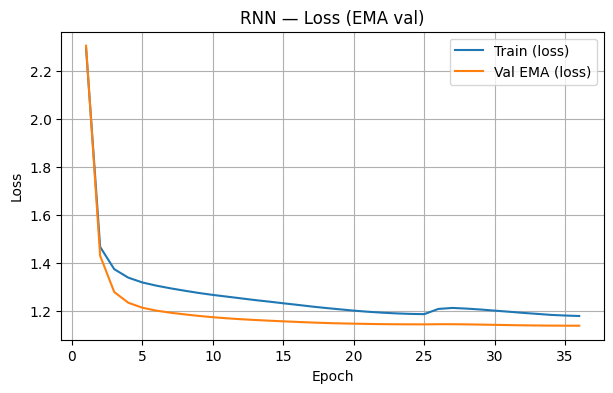

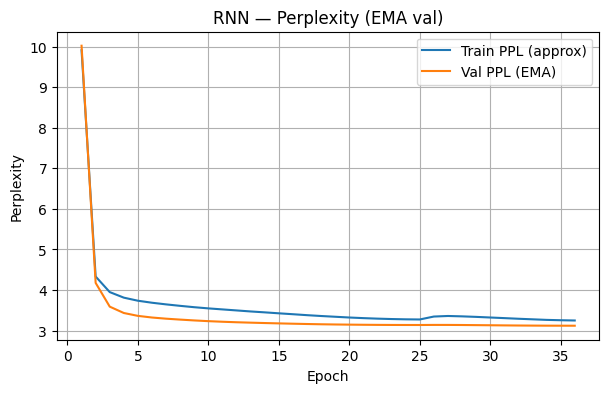

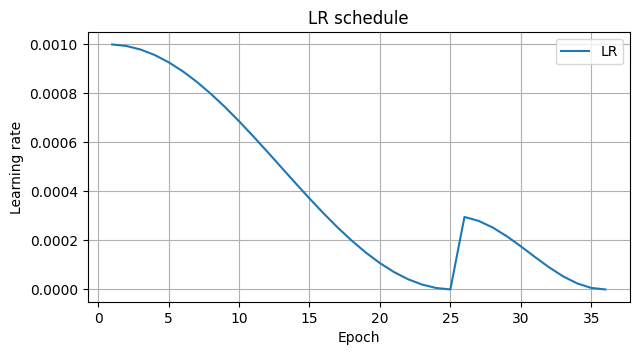

In [17]:
# ============================================================
# == STEP 3: Model: Vanilla RNN (tied softmax + optional proj) ==
# ============================================================
print("== STEP 3: RNN defined ==")

def init_rnn_params(key, vocab_size, embed_dim, hidden_size,
                    tie_weights=TIE_WEIGHTS, use_proj=USE_PROJ, use_ln=USE_LAYER_NORM):
    k = jrand.split(key, 10)
    p = {}
    # Embedding
    p["embedding"] = jrand.normal(k[0], (vocab_size, embed_dim)) * 0.02
    # RNN weights
    p["W_xh"] = jrand.normal(k[1], (embed_dim, hidden_size)) * 0.02
    p["W_hh"] = jrand.normal(k[2], (hidden_size, hidden_size)) * 0.02
    p["b_h"]  = jnp.zeros((hidden_size,))
    # Learnable LayerNorm params (on hidden pre-activation)
    if use_ln:
        p["ln_gamma"] = jnp.ones((hidden_size,))
        p["ln_beta"]  = jnp.zeros((hidden_size,))
    # Output: tied or untied
    if tie_weights:
        p["b_y"] = jnp.zeros((vocab_size,))
        if use_proj and (hidden_size != embed_dim):
            p["W_proj"] = jrand.normal(k[3], (hidden_size, embed_dim)) * 0.02
    else:
        p["W_hy"] = jrand.normal(k[4], (hidden_size, vocab_size)) * 0.02
        p["b_y"]  = jnp.zeros((vocab_size,))
    return p

def layer_norm_with_params(x, gamma, beta, eps=1e-5):
    mu  = jnp.mean(x, axis=-1, keepdims=True)
    var = jnp.mean((x - mu) ** 2, axis=-1, keepdims=True)
    xhat = (x - mu) / jnp.sqrt(var + eps)
    return gamma * xhat + beta

def maybe_layer_norm(params, x):
    if not USE_LAYER_NORM:
        return x
    return layer_norm_with_params(x, params["ln_gamma"], params["ln_beta"])

def rnn_step(params, h_prev, x_t_ids):
    E = params["embedding"]                   # (V,D)
    D = E.shape[1]
    x = E[x_t_ids]                            # (B,D)
    pre = x @ params["W_xh"] + h_prev @ params["W_hh"] + params["b_h"]
    h  = jnp.tanh(maybe_layer_norm(params, pre))
    if "W_hy" in params:
        logits = h @ params["W_hy"] + params["b_y"]
    else:
        if ("W_proj" in params) and (h.shape[1] != D):
            h_out = h @ params["W_proj"]
        else:
            h_out = h
        logits = h_out @ E.T + params["b_y"]
    return h, logits

def rnn_forward_dropout(params, x_seq, rng_key, is_training: bool,
                        emb_dropout=EMB_DROPOUT,
                        hidden_dropout=HIDDEN_DROPOUT,
                        out_dropout=OUT_DROPOUT):
    # Variational dropout masks (locked across time) for speed/stability.
    B, T = x_seq.shape
    E = params["embedding"]; D = E.shape[1]
    H = params["b_h"].shape[0]
    rng_key, kE, kH, kO = jrand.split(rng_key, 4)

    emb_mask = jnp.ones((B, D))
    if is_training and emb_dropout > 0.0:
        keep = 1.0 - emb_dropout
        emb_mask = jrand.bernoulli(kE, p=keep, shape=(B, D)) / keep

    hid_mask = jnp.ones((B, H))
    if is_training and hidden_dropout > 0.0:
        keep = 1.0 - hidden_dropout
        hid_mask = jrand.bernoulli(kH, p=keep, shape=(B, H)) / keep

    if "W_hy" in params:
        out_dim = H
    else:
        out_dim = D if (("W_proj" in params) and (H != D)) else H
    out_mask = jnp.ones((B, out_dim))
    if is_training and out_dropout > 0.0:
        keep = 1.0 - out_dropout
        out_mask = jrand.bernoulli(kO, p=keep, shape=(B, out_dim)) / keep

    def step(carry, x_t):
        h_prev = carry
        x_emb  = E[x_t] * emb_mask
        pre    = x_emb @ params["W_xh"] + h_prev @ params["W_hh"] + params["b_h"]
        h_t    = jnp.tanh(maybe_layer_norm(params, pre))
        h_do   = h_t * hid_mask

        if "W_hy" in params:
            h_out = h_do * out_mask
            logits = h_out @ params["W_hy"] + params["b_y"]
        else:
            if ("W_proj" in params) and (H != D):
                h_out = (h_do @ params["W_proj"]) * out_mask
            else:
                h_out = (h_do) * out_mask
            logits = h_out @ E.T + params["b_y"]
        return h_t, logits

    h0 = jnp.zeros((B, H))
    xs_t = x_seq.T
    _, ys_t = lax.scan(step, h0, xs_t)       # (T,B,V)
    return jnp.transpose(ys_t, (1,0,2))      # (B,T,V)

# ============================================================
# == STEP 4: Optimizer, EMA, schedules, loss ==
# ============================================================
print("== STEP 4: Optimizer & helpers ready ==")

def _l2_weight_decay(params, exclude_bias=True, exclude_embedding=True):
    sq = 0.0
    for name, p in params.items():
        if exclude_bias and (name.startswith('b') or name in ('b_h','b_y')):
            continue
        if exclude_embedding and (name == 'embedding'):
            continue
        sq = sq + jnp.sum(p * p)
    return sq

def lm_loss_reg(params, x, y, rng=None, is_training: bool = False):
    # Standard xent + light WD (no WD on embedding/bias)
    if rng is None:
        logits = rnn_forward_dropout(params, x, jrand.PRNGKey(0), False)
    else:
        logits = rnn_forward_dropout(params, x, rng, is_training)
    logp = jax.nn.log_softmax(logits, axis=-1)
    tok_logp = jnp.take_along_axis(logp, y[..., None], axis=-1).squeeze(-1)
    nll = -jnp.mean(tok_logp)
    reg = WEIGHT_DECAY * _l2_weight_decay(params, True, True)
    return nll + reg

def init_adam_state(params):
    tm = jax.tree_util.tree_map(jnp.zeros_like, params)
    tv = jax.tree_util.tree_map(jnp.zeros_like, params)
    return {"m": tm, "v": tv, "t": jnp.array(0, dtype=jnp.int32)}

def clip_grads(grads, max_norm=GRAD_CLIP_NORM):
    sqsum = sum([jnp.sum(g*g) for g in jax.tree_util.tree_leaves(grads)])
    norm = jnp.sqrt(sqsum) + 1e-12
    scale = jnp.minimum(1.0, max_norm / norm)
    return jax.tree_util.tree_map(lambda g: g * scale, grads)

@jax.jit
def adam_update(params, grads, state, lr=LEARNING_RATE, b1=0.9, b2=0.999, eps=1e-8):
    t = state["t"] + 1
    m = jax.tree_util.tree_map(lambda m,g: b1*m + (1-b1)*g, state["m"], grads)
    v = jax.tree_util.tree_map(lambda v,g: b2*v + (1-b2)*(g*g), state["v"], grads)
    mhat = jax.tree_util.tree_map(lambda x: x / (1 - b1**t), m)
    vhat = jax.tree_util.tree_map(lambda x: x / (1 - b2**t), v)
    new_params = jax.tree_util.tree_map(lambda p,mh,vh: p - lr * mh / (jnp.sqrt(vh) + eps),
                                        params, mhat, vhat)
    return new_params, {"m": m, "v": v, "t": t}

def cosine_decay(step, total_steps, base_lr=LEARNING_RATE, warmup=WARMUP_FRACTION):
    warm_steps = int(total_steps * warmup)
    def lr_fn(s):
        s = jnp.minimum(s, total_steps)
        lr = jnp.where(
            s < warm_steps,
            base_lr * (s / jnp.maximum(1, warm_steps)),
            0.5 * base_lr * (1 + jnp.cos(jnp.pi * (s - warm_steps) / jnp.maximum(1, total_steps - warm_steps)))
        )
        return lr
    return float(lr_fn(step))

@functools.partial(jax.jit, static_argnums=())
def train_step(params, opt_state, x_batch, y_batch, lr, rng):
    def loss_fn(p):
        return lm_loss_reg(p, x_batch, y_batch, rng=rng, is_training=True)
    loss, grads = jax.value_and_grad(loss_fn)(params)
    grads = clip_grads(grads, GRAD_CLIP_NORM)
    new_params, new_opt = adam_update(params, grads, opt_state, lr=lr)
    return new_params, new_opt, loss

# EMA helpers
def init_ema_params(params):
    return jax.tree_util.tree_map(lambda p: p.copy(), params)

def ema_update(ema_params, params, decay=EMA_DECAY):
    return jax.tree_util.tree_map(lambda e, p: decay*e + (1.0-decay)*p, ema_params, params)

# ============================================================
# == STEP 5: Training (cosine LR + one restart + early stop) ==
# ============================================================
print("== STEP 5: Training (Exercise 1) ==")

def batch_iterator(x, y, batch_size, key, steps_cap=None):
    n = x.shape[0]
    idx = jnp.arange(n)
    perm = jrand.permutation(key, idx)
    steps = 0
    for s in range(0, n, batch_size):
        if steps_cap is not None and steps >= steps_cap:
            break
        bidx = perm[s:s+batch_size]
        steps += 1
        yield x[bidx], y[bidx]

def train_rnn_fixed_windows(x_train, y_train, x_val, y_val,
                            vocab_size, embed_dim, hidden_size,
                            epochs, batch_size, base_lr, base_seed):
    key = jrand.PRNGKey(base_seed)
    params = init_rnn_params(key, vocab_size, embed_dim, hidden_size,
                             tie_weights=TIE_WEIGHTS, use_proj=USE_PROJ, use_ln=USE_LAYER_NORM)
    opt_state = init_adam_state(params)
    ema_params = init_ema_params(params)

    steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
    if STEPS_PER_EPOCH_CAP is not None:
        steps_per_epoch = min(steps_per_epoch, STEPS_PER_EPOCH_CAP)
    total_steps = epochs * steps_per_epoch
    split_point = int(total_steps * 0.7)

    # Early stopping
    patience   = 6
    min_delta  = 8e-4
    best_vl    = float('inf')
    stale_ep   = 0

    train_losses, val_losses, lrs = [], [], []
    global_step = 0
    t0 = time.time()

    # Warm up JIT once on a tiny batch
    wb = min(8, x_train.shape[0])
    _ = train_step(params, opt_state, x_train[:wb], y_train[:wb],
                   lr=LEARNING_RATE, rng=jrand.PRNGKey(0))

    for epoch in range(1, epochs+1):
        epoch_wall_start = time.time()
        epoch_ctime = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch_wall_start))
        key, ek = jrand.split(key)
        tot, steps = 0.0, 0

        for xb, yb in batch_iterator(x_train, y_train, batch_size, ek, steps_cap=STEPS_PER_EPOCH_CAP):
            # Cosine LR with one restart at 70% progress
            if global_step < split_point:
                lr_now = cosine_decay(global_step, split_point, base_lr=base_lr, warmup=WARMUP_FRACTION)
            else:
                step2  = global_step - split_point
                total2 = total_steps - split_point
                lr_now = cosine_decay(step2, total2, base_lr=base_lr*0.3, warmup=0.0)

            key, batch_key = jrand.split(key)
            params, opt_state, loss = train_step(params, opt_state, xb, yb, lr=lr_now, rng=batch_key)

            # EMA every step
            ema_params = ema_update(ema_params, params, decay=EMA_DECAY)

            global_step += 1
            tot += float(loss); steps += 1

        tr = tot / max(1, steps)

        # Track EMA val during training for smoother decisions
        vl = float(lm_loss_reg(ema_params, x_val, y_val, rng=None, is_training=False))
        train_losses.append(tr); val_losses.append(vl); lrs.append(lr_now)

        epoch_sec = time.time() - epoch_wall_start
        cum_min = (time.time() - t0) / 60.0
        print(f"[Epoch {epoch:02d}] {epoch_ctime} | +{epoch_sec:6.2f}s (cum {cum_min:5.2f}m) "
              f"Train {tr:.4f} | Val {vl:.4f} | Val PPL {math.exp(vl):.2f} | LR {lr_now:.6f}")

        # Early stop on EMA val
        if vl + min_delta < best_vl:
            best_vl  = vl
            stale_ep = 0
        else:
            stale_ep += 1
        if stale_ep >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement ≥ {min_delta} for {patience} epochs).")
            break

    mins = (time.time() - t0)/60.0
    print(f"Training done in {mins:.2f} min")
    return params, ema_params, train_losses, val_losses, lrs

# ---- Train ----
params, ema_params, train_losses, val_losses, lrs = train_rnn_fixed_windows(
    x_train, y_train, x_val, y_val,
    vocab_size=vocab_size, embed_dim=EMBED_DIM, hidden_size=HIDDEN_SIZE,
    epochs=EPOCHS, batch_size=BATCH_SIZE, base_lr=LEARNING_RATE, base_seed=BASE_SEED
)

best_val = min(val_losses); best_ep = 1 + val_losses.index(best_val)
print(f"\nBest EMA-Val loss: {best_val:.4f} (epoch {best_ep}) | Val PPL: {math.exp(best_val):.2f}")

# ============================================================
# == STEP 6: Eval + Plots (compute both EMA & NON-EMA) ==
# ============================================================
print("\n== STEP 6: Eval + Plots ==")

final_train = float(train_losses[-1])
val_loss_nonema = float(lm_loss_reg(params,   x_val,  y_val,  rng=None, is_training=False))
val_loss_ema    = float(lm_loss_reg(ema_params, x_val,  y_val,  rng=None, is_training=False))
test_loss_nonema= float(lm_loss_reg(params,   x_test, y_test, rng=None, is_training=False))
test_loss_ema   = float(lm_loss_reg(ema_params, x_test, y_test, rng=None, is_training=False))

print(f"Train (last epoch avg loss): {final_train:.4f}")
print(f"Val (NON-EMA): {val_loss_nonema:.4f} | PPL: {math.exp(val_loss_nonema):.2f}")
print(f"Val (EMA):     {val_loss_ema:.4f} | PPL: {math.exp(val_loss_ema):.2f}")
print(f"Test (NON-EMA): {test_loss_nonema:.4f} | PPL: {math.exp(test_loss_nonema):.2f}")
print(f"Test (EMA):     {test_loss_ema:.4f} | PPL: {math.exp(test_loss_ema):.2f}")

# Curves (EMA val shown for continuity)
epochs_axis = list(range(1, len(train_losses)+1))
train_ppl_curve   = [math.exp(x) for x in train_losses]
val_ppl_curve_ema = [math.exp(x) for x in val_losses]

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_losses, label="Train (loss)")
plt.plot(epochs_axis, val_losses,   label="Val EMA (loss)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("RNN — Loss (EMA val)")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_ppl_curve,   label="Train PPL (approx)")
plt.plot(epochs_axis, val_ppl_curve_ema, label="Val PPL (EMA)")
plt.xlabel("Epoch"); plt.ylabel("Perplexity"); plt.title("RNN — Perplexity (EMA val)")
plt.grid(True); plt.legend(); plt.show()

if len(lrs) == len(epochs_axis):
    plt.figure(figsize=(7,3.5))
    plt.plot(epochs_axis, lrs, label="LR")
    plt.xlabel("Epoch"); plt.ylabel("Learning rate"); plt.title("LR schedule")
    plt.grid(True); plt.legend(); plt.show()

### Exercise 2: Autoregressive generation (3 points)

For this exercise, run the trained model in an autoregressive fashion and show some examples of generated sequences. Note that the details will depend on the specific type of data (e.g., sampling text tokens, sampling pixels as discrete values, sampling pixels from a continuous range of colours, ...). For this, refer also to Section 8.4 of the book.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Show some examples of generated sequences.*

---

When performing **autoregressive generation**, the model generates sequences by predicting **one token at a time** and feeding it back into the network. In this script, the model operates at the **character level**, producing the next character based on the current hidden state and all previously generated tokens. Instead of always taking the most probable token, we use **top-p (nucleus) sampling** to randomly select among the most likely tokens, which improves diversity. Additionally, a **repetition penalty** discourages the model from repeatedly generating the same tokens.

### Key Steps in This Implementation
1. **Prompt processing**: The input text prompt is converted to token IDs, prepending special tokens (BOS and speaker) if necessary, and lowercasing the content.  
2. **Hidden state warmup**: The RNN processes the prompt to update its hidden state before generating new tokens.  
3. **Token-by-token generation loop**:
   - Compute the logits for the next token using `rnn_step`.
   - Scale logits by **temperature** to control randomness.
   - Apply **repetition penalty** and **mask special tokens** (like UNK or BOS) to avoid invalid outputs.
   - Apply **top-p filtering** to keep only the most probable tokens.
   - Sample the next token from the filtered probability distribution.
   - Append the selected token to the output sequence and update the hidden state.
4. **Stop condition**: The loop ends either when reaching `max_len` tokens or generating an **EOS** token.  
5. **Decoding**: Convert the generated token IDs back into characters to produce the final text sequence.

This approach allows the model to generate coherent sequences that respect learned character-level patterns while introducing controlled randomness for more diverse outputs.


In [18]:

# Top-p (nucleus) filtering
# ---------------------------
def topp_filter(logits, p=TOPP_P):
    """
    Filters logits to keep the minimal set of tokens whose cumulative
    probability exceeds `p`. All other logits are set to a large negative
    value to effectively remove them from sampling.
    """
    probs = jax.nn.softmax(logits)
    idx = jnp.argsort(-probs)          # descending sort
    sorted_probs = probs[idx]
    csum = jnp.cumsum(sorted_probs)    # cumulative sum
    cutoff = jnp.argmax(csum >= p)
    cutoff = jnp.maximum(cutoff, 1)   # ensure at least 1 token
    keep_idx = idx[:cutoff+1]
    mask = jnp.full_like(logits, -1e9)
    return mask.at[keep_idx].set(logits[keep_idx])

# ---------------------------
# Repetition penalty
# ---------------------------
def apply_repetition_penalty(logits, generated_ids, penalty=REP_PENALTY):
    """
    Reduces logits of already generated tokens to discourage repetition.
    """
    if not generated_ids:
        return logits
    uniq = jnp.array(list(set(generated_ids)))
    return logits.at[uniq].set(logits[uniq] / penalty)

# ---------------------------
# Warmup hidden state
# ---------------------------
def rnn_warmup_hidden(params, token_ids):
    """
    Computes the hidden state after consuming an initial sequence.
    """
    H = params["b_h"].shape[0]
    h = jnp.zeros((1, H))
    for t in token_ids:
        x_t = jnp.array([int(t)], dtype=jnp.int32)
        h, _ = rnn_step(params, h, x_t)
    return h

# ---------------------------
# Ensure prompt IDs
# ---------------------------
def ensure_prompt_ids(prompt, c2i):
    """
    Converts a text prompt into a list of token IDs.
    Prepends BOS + speaker token if missing and lowercases the text.
    """
    if not prompt or prompt[0] != BOS_CHAR:
        prompt = BOS_CHAR + SPK_A + prompt
    head, tail = prompt[:2], prompt[2:]
    prompt_fixed = head + tail.lower()
    return [c2i.get(ch, c2i[UNK_CHAR]) for ch in prompt_fixed]

# ---------------------------
# Mask special tokens
# ---------------------------
def mask_specials_for_decode(logits, allow_eos=True, allow_bos=False):
    """
    Masks out UNK and optionally BOS to prevent invalid decoding.
    """
    mask_ids = [UNK_ID]
    if not allow_bos:
        mask_ids.append(BOS_ID)
    for mid in mask_ids:
        logits = logits.at[mid].set(-1e9)
    return logits

# ---------------------------
# Autoregressive generation
# ---------------------------
def generate_text(params_for_gen, prompt, max_len=140, temperature=DEFAULT_TEMP,
                  top_p=TOPP_P, rep_penalty=REP_PENALTY, stop_on_eos=True):
    """
    Generates text token by token in an autoregressive manner.
    Applies top-p filtering and repetition penalty at each step.
    """
    c2i, i2c = char2idx, idx2char
    prompt_ids = ensure_prompt_ids(prompt, c2i)
    h = rnn_warmup_hidden(params_for_gen, prompt_ids)
    out_ids = list(prompt_ids)
    prev_id = out_ids[-1]

    for i in range(max_len):
        # Forward pass
        x_t = jnp.array([prev_id], dtype=jnp.int32)
        h, logits = rnn_step(params_for_gen, h, x_t)

        # Scale logits by temperature
        logits = logits[0] / max(1e-6, temperature)

        # Apply repetition penalty and mask special tokens
        logits = apply_repetition_penalty(logits, out_ids, penalty=rep_penalty)
        logits = mask_specials_for_decode(logits, allow_eos=True, allow_bos=False)

        # Apply top-p filtering
        logits = topp_filter(logits, p=top_p)

        # Sample next token
        probs  = jax.nn.softmax(logits)
        key = jrand.PRNGKey(1000 + i)
        next_id = int(jrand.choice(key, probs.shape[0], p=probs))

        out_ids.append(next_id)
        prev_id = next_id

        # Stop if EOS token generated
        if stop_on_eos and next_id == EOS_ID:
            break

    return "".join(i2c[i] for i in out_ids)

# ---------------------------
# Quick autoregressive generation demo
# ---------------------------
GEN_PARAMS = params  # Use NON-EMA parameters for generation
samples = [("Hi, ", 0.8), ("Why are", 1.0), ("I think", 0.9), ("", 1.0)]

for prompt, temp in samples:
    print("\n" + "="*60)
    print(f"Sampling | T={temp} | top_p={TOPP_P} | rep_penalty={REP_PENALTY}")
    print("PROMPT:", repr(prompt))
    print("-"*60)
    s = generate_text(GEN_PARAMS, prompt, max_len=120, temperature=temp, top_p=TOPP_P, rep_penalty=REP_PENALTY)
    print(s)



Sampling | T=0.8 | top_p=0.92 | rep_penalty=1.15
PROMPT: 'Hi, '
------------------------------------------------------------
␂①hi, and a car is so full . hey ! good . i'll see it for me .␞

Sampling | T=1.0 | top_p=0.92 | rep_penalty=1.15
PROMPT: 'Why are'
------------------------------------------------------------
␂①why ares , all the book send in your door ? that's the new health .␞

Sampling | T=0.9 | top_p=0.92 | rep_penalty=1.15
PROMPT: 'I think'
------------------------------------------------------------
␂①i think you all know how is going because i really want to go over the regards to get a call well . then , and i would go out o

Sampling | T=1.0 | top_p=0.92 | rep_penalty=1.15
PROMPT: ''
------------------------------------------------------------
␂①hold about it .␞


### Exercise 3: Beam search (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercises 1&2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1&2&3 for a total of *15 points*.

In standard autoregressive modeling, at every iteration you sample the element with the highest associated probability (e.g., the $\arg\max$ for a discrete distribution). This is known as **greedy decoding**. However, this may result in completed sequences with low probability.

A common modification is **beam search** ([link](https://d2l.ai/chapter_recurrent-modern/beam-search.html)), where at every iteration we keep track of $k$ possible sequences (called **beams**). See also Section 8.4.2 in the book.

**TODO**: For this exercise, implement a beam search decoding procedure for your model, and show some examples of generation, comparing them to the result of greedy decoding.

---

In **beam search decoding**, unlike standard greedy or autoregressive generation where only the most probable next token is chosen, we maintain multiple candidate sequences (beams) at each step. Each beam tracks:

- Its current **hidden state** in the RNN.
- The **sequence of tokens** generated so far.
- The **cumulative log-probability** of that sequence.

At each decoding step, all beams are expanded by considering every possible next token. The cumulative log-probabilities of these expanded sequences are computed, and only the top `beam_size` sequences are retained. This allows the model to explore multiple promising paths simultaneously, often resulting in more coherent and higher-probability sequences compared to greedy decoding.

### Key Steps in This Implementation
1. **Prompt encoding & hidden state warmup**: Convert the input text prompt into token IDs and run them through the RNN to initialize the hidden state for all beams.  
2. **Beam initialization**: Start with one beam containing the prompt and assign very low log-probabilities to the remaining beams to ensure only the first is active initially.  
3. **Beam search loop** (for `length` steps):
   - For each beam, perform a forward pass to get logits for the next token.
   - Apply temperature scaling and mask out special tokens.
   - Convert logits to log-probabilities and add them to the beam’s cumulative log-prob.
   - Force finished beams (with EOS) to remain finished.
   - Flatten all possible expansions across beams, select the top `beam_size` sequences, and update their hidden states and token sequences.
   - Optionally, normalize scores with a **length penalty** (`alpha`) to avoid favoring shorter sequences.
4. **Selection & decoding**: After completing the loop, select the beam with the highest normalized log-probability and convert its token IDs back to characters.

### Demo
The code compares **beam search** (e.g., beam size = 4) to standard **greedy/autoregressive generation** for several prompts. You can observe how beam search tends to produce more coherent or complete outputs while greedy generation might get stuck in locally optimal but lower-quality sequences. This approach is implemented **fully in JAX**, relying on `lax.scan` and `vmap` for efficiency without external frameworks.


In [19]:

def beam_search_decode(params_for_gen, prompt, beam_size=BEAM_SIZE, length=120,
                       temperature=DEFAULT_TEMP, alpha=BEAM_LEN_ALPHA, stop_on_eos=True):
    """
    Performs beam search decoding on the trained RNN model.
    Returns the highest scoring sequence (length-normalized if alpha>0).
    """
    c2i, i2c = char2idx, idx2char
    prompt_ids = ensure_prompt_ids(prompt, c2i)
    H = params_for_gen["b_h"].shape[0]

    # Warmup hidden state for the prompt
    h0 = rnn_warmup_hidden(params_for_gen, prompt_ids)   # shape (1,H)

    # Initialize beam states and sequences
    total_len = len(prompt_ids) + length
    beam_states = jnp.tile(h0, (beam_size, 1))           # shape (B,H)
    beam_seq = -jnp.ones((beam_size, total_len), dtype=jnp.int32)
    if len(prompt_ids) > 0:
        beam_seq = beam_seq.at[0, :len(prompt_ids)].set(jnp.array(prompt_ids, dtype=jnp.int32))
    beam_logp = jnp.array([0.0] + [-1e10]*(beam_size-1), dtype=jnp.float32)
    step_idx = jnp.array(0, dtype=jnp.int32)

    # Single forward pass for a batch of tokens
    def single_forward(h_in, token_id):
        h_out, logits = rnn_step(params_for_gen, h_in[None,:], jnp.array([token_id], dtype=jnp.int32))
        logits = logits[0] / max(1e-6, temperature)
        logits = mask_specials_for_decode(logits, allow_eos=True, allow_bos=False)
        return h_out[0], logits

    # Beam search step
    def beam_step(carry, _):
        beam_states, beam_seq, beam_logp, step_idx = carry
        pos = len(prompt_ids) + step_idx

        # Get last token of each beam
        last_tokens = lax.cond(pos > 0, lambda p: beam_seq[:, p-1],
                               lambda p: jnp.zeros((beam_size,), dtype=jnp.int32), pos)

        # Forward pass
        h_next, logits = jax.vmap(single_forward)(beam_states, last_tokens)
        log_probs = nn.log_softmax(logits, axis=-1)

        # Force finished beams to stay finished
        if stop_on_eos:
            alive = (last_tokens != EOS_ID).astype(jnp.float32)[:, None]
            log_probs = log_probs * alive + (-1e9) * (1.0 - alive)

        # Compute new log probabilities for all beam expansions
        new_logp = beam_logp[:, None] + log_probs
        flat = new_logp.reshape(-1)
        topk_lp, topk_idx = lax.top_k(flat, beam_size)
        V = logits.shape[1]
        beam_ids = topk_idx // V
        tok_ids  = topk_idx % V

        # Update beam states and sequences
        chosen_states = h_next[beam_ids]
        chosen_seq    = beam_seq[beam_ids]
        chosen_seq = chosen_seq.at[jnp.arange(beam_size), pos].set(tok_ids)
        len_after = pos + 1
        norm = ((5.0 + len_after) / 6.0) ** alpha
        topk_lp_norm = topk_lp / norm
        return (chosen_states, chosen_seq, topk_lp_norm, step_idx + 1), None

    # Run beam search for the required length
    final_carry, _ = lax.scan(beam_step, (beam_states, beam_seq, beam_logp, step_idx),
                              xs=None, length=length)
    _, final_seq, final_lp, _ = final_carry
    best = jnp.argmax(final_lp)
    seq = final_seq[best]

    # Convert token IDs to characters
    out_chars = []
    for t in seq:
        if t == -1:
            continue
        if stop_on_eos and int(t) == EOS_ID:
            out_chars.append(idx2char[int(t)])
            break
        out_chars.append(idx2char[int(t)])
    return "".join(out_chars)

# ---------------------------
# Quick beam search demo
# ---------------------------
prompts = ["Hi, ", "Why are", "I think", ""]
for p in prompts:
    print("\n" + "="*60)
    print(f"Prompt: {repr(p)}")

    # Beam search generation
    print("[Beam-4]")
    b = beam_search_decode(GEN_PARAMS, p, beam_size=BEAM_SIZE, length=100,
                           temperature=DEFAULT_TEMP, alpha=BEAM_LEN_ALPHA)
    print("", b)

    # Greedy/autoregressive generation for comparison
    print("\n[Greedy-ish]")
    g = generate_text(GEN_PARAMS, p, max_len=100,
                      temperature=DEFAULT_TEMP, top_p=TOPP_P, rep_penalty=1.0)
    print("", g)

print("\n== All steps complete ==")



Prompt: 'Hi, '
[Beam-4]
 ␂①hi, , that's a good idea . i was too long . i will take the same thing . i would like to have a look at 

[Greedy-ish]
 ␂①hi, and a car is so excited .␞

Prompt: 'Why are'
[Beam-4]
 ␂①why ared that i want to see you then ? i want to get a bit too . it was a good idea . i was too bad . i wil

[Greedy-ish]
 ␂①why ared , but the book the channels have been helpoded for the company . and would you like to work here ?

Prompt: 'I think'
[Beam-4]
 ␂①i think you sometimes be able to get to the computer . it was a good idea . well , i want to get a bit too 

[Greedy-ish]
 ␂①i think the back of the same candrd . the children there brother and david offer the chance to start and ca

Prompt: ''
[Beam-4]
 ␂①are you going to be able to go to the computer ? i don ' t know where they are . i was too bad . wha

[Greedy-ish]
 ␂①hous , and i think that it's being a party at the moment , but i just want to change to try . i had 

== All steps complete ==


### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

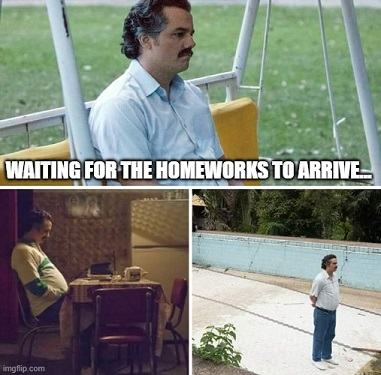